## This notebook is a dead end, look at `swing_on_ball.ipynb` instead.

In [172]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-swing-on-ball.csv")

df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
# select season (zero indexed)
season = 12
df_balls = df_balls[df_balls["season"] == season]

/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_42274/3372704875.py:10: DtypeWarning: Columns (116) have mixed types. Specify dtype option on import or set low_memory=False.
  df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_42274/3372704875.py:10: DtypeWarning: Columns (116) have mixed types. Specify dtype option on import or set low_memory=False.
  df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_42274/3372704875.py:10: DtypeWarning: Columns (116) have mixed types. Specify dtype option on import or set low_memory=False.
  df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [173]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]  # * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]  # * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]  # * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2 / freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes


def get_pitcher_mul(row):
    bm = str(row["batter_mods"])
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass  # traveling just doesn't do anything on pitchers?
    #         if not row["top_of_inning"]:
    #             mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #         mul += min(0.05, 0.05 * (row["day"] / 99))
        pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    #         pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        #         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
    #         pass
    return mul

In [174]:
# additions and corrections, global

df_balls["batter_mul"] = df_balls.apply(get_batter_mul, axis=1)
df_balls["pitcher_mul"] = df_balls.apply(get_pitcher_mul, axis=1)

df_balls.loc[df_balls["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df_balls.loc[df_balls["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

df_balls["ruth_scaled"] = df_balls["pitcher_ruthlessness"] * df_balls["pitcher_mul"]
df_balls["mox_scaled"] = df_balls["batter_moxie"] * df_balls["batter_mul"]
df_balls["path_scaled"] = df_balls["batter_patheticism"] / df_balls["batter_mul"]

df_balls["batter_eye"] = df_balls["mox_scaled"] - df_balls["path_scaled"]

df_balls["invpath"] = 1 - df_balls["batter_patheticism"]
df_balls["invpath_scaled"] = 1 - df_balls["batter_patheticism"] / df_balls["batter_mul"]
# df_balls["path_scaled"] = 1 - ((1 - df_balls["batter_patheticism"]) * df_balls["batter_mul"])
# df_balls["mox_path"] = df_balls["mox_scaled"] - df_balls["path_scaled"]
# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [175]:
# df = df[(df["batting_team_hype"] == 0) & (df['pitching_team_hype'] == 0)]

# df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * (1 + 0.2 * df_balls["pitcher_vibes"])
# df_balls["mox_vibes"] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls["mox_vibes"] = df_balls["mox_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

# thought this might help but it seems not to help
df_balls["invpath_vibes"] = df_balls["invpath_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

# beiju's idea
df_balls["visc_filth"] = df_balls["ballpark_viscosity"] * df_balls["ballpark_filthiness"]
# # put in our "best fit" up here in the original df, just because
# df['svc_best'] = 0.30 * df["ruth_scaled"] + 0.20 * df["ballpark_forwardness"] \
#                   + 0.06 * df["ruth_vibes"] + 0.10 * df["musc_scaled"]

df_balls["ruth_times_vibes"] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls["mox_times_vibes"] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls["path_times_vibes"] = df_balls["path_scaled"] * df_balls["batter_vibes"]


# kidror's idea
df_balls["ruth_sq"] = df_balls["ruth_vibes"] ** 2
df_balls["mox_sq"] = df_balls["mox_vibes"] ** 2
# df_balls["path_sq"] = df_balls["path_scaled"]**2 # not path_vibes
df_balls["visc_sq"] = df_balls["ballpark_viscosity"] ** 2

In [210]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]

# just look at swinging on balls first
dfc = df_balls.copy()
for exclude_mod in [
    "OVERPERFORMING",
    "UNDERPERFORMING",
    "HIGH_PRESSURE",
    "GROWTH",
    "SINKING_SHIP",
    "TRAVELING",
    "AFFINITY_FOR_CROWS",
    "CHUNKY",
    "SMOOTH",
    "ON_FIRE",
]:
    # for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    # exclude flinch situations entirely...superfluous i think, it doesn't roll when flinching
    dfc = dfc[~((dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0))]
    
dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["batter_mul"] == 1)]


In [211]:
# print(list(df_balls.columns))
print(57959, "old length of full csv")
print(len(df_balls))
print(len(dfc))

57959 old length of full csv
106224
71151


In [212]:
digest_list = [
    "event_type",
    "roll",
    "batter_name",
    "pitcher_name",
    "ruth_scaled",
    "pitcher_vibes",
    "musc_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
    "svc_best",
]

In [213]:
# print(coef_list, intercept_scaled)
# print(X.columns)

In [214]:
dfc[dfc["passed"] == True]["roll"].max()

0.9459152756661806

In [215]:
dfc[dfc["passed"] == False]["roll"].min()

0.0005637794240207

In [216]:
# max for swings seems to be 0.95 so remove rolls above that
dfc = dfc[dfc["roll"] < 0.95]
# weird "cutoff" at 0.1 (though you can take pitches below this!) so remove rolls below that
dfc = dfc[dfc["roll"] > 0.1]
len(dfc)

60416

In [217]:
# df_balls[(df_balls["passed"] == True) & (df_balls["roll"] < 0.1)]["threshold"].min()

In [218]:
dfc.groupby("batter_mul").head(1)[["batter_mul", "batter_name"]].sort_values("batter_mul", ascending=False)[0:10]

,batter_mul,batter_name
0,1.0,Bates Bentley


In [219]:
print(list(df_balls.columns))

['event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'runner_on_first_base_thirst', 'runner_on_first_continuation', 'runner_on_first_ground_friction', 'runner_on_first_indulgence', 'runner_on_first_laserlikeness', 'runner_on_first_multiplier', 'runner_on_second_base_thirst', 'runner_on_second_continuation', 'runner_on_second_ground_friction', 'runner_on_second_indulgence', 'runner_on_second_laserlikeness', 'runner_on_s

In [220]:
for dfs in [dfc, df_balls]:
    # calculate cross terms, I guess
    dfs["ruthsq"] = dfs["ruth_vibes"] * dfs["ruth_vibes"]
    dfs["pathsq"] = dfs["invpath_scaled"] * dfs["invpath_scaled"]
    # dfc['pathsq'] = dfc['invpath_vibes'] * dfc['invpath_vibes']
    dfs["moxsq"] = dfs["mox_vibes"] * dfs["mox_vibes"]
    dfs["viscsq"] = dfs["ballpark_viscosity"] * dfs["ballpark_viscosity"]
    dfs["ruthmox"] = dfs["ruth_vibes"] * dfs["mox_vibes"]
    dfs["ruthpath"] = dfs["ruth_vibes"] * dfs["invpath_scaled"]
    dfs["ruthvisc"] = dfs["ruth_vibes"] * dfs["ballpark_viscosity"]
    dfs["moxpath"] = dfs["mox_vibes"] * dfs["invpath_scaled"]
    dfs["moxvisc"] = dfs["mox_vibes"] * dfs["ballpark_viscosity"]
    dfs["pathvisc"] = dfs["invpath_scaled"] * dfs["ballpark_viscosity"]

    dfs["moxpluspath"] = dfs["mox_vibes"] + dfs["invpath_scaled"]
    dfs["mpsq"] = dfs["moxpluspath"] * dfs["moxpluspath"]
    dfs["ruthmp"] = dfs["ruth_vibes"] * dfs["moxpluspath"]
    dfs["viscmp"] = dfs["ballpark_viscosity"] * dfs["moxpluspath"]

    # doesn't work i think
    dfs["ruthpluseye"] = 0.5 * dfs["ruth_vibes"] + 0.2 * dfs["moxpluspath"]
    dfs["rutheyesq"] = dfs["ruthpluseye"] * dfs["ruthpluseye"]
    dfs["viscrutheye"] = dfs["ballpark_viscosity"] * dfs["ruthpluseye"]

In [221]:
# X = dfc[['roll', *dfc.columns[5:-11]]].drop('pitcher_name', axis=1).drop('batter_mods', axis=1)\
#     .drop('batting_team_mods', axis=1).drop('pitching_team_mods', axis=1).drop('pitcher_mods', axis=1)\
#     .drop('batter_vibes', axis=1).drop('pitcher_vibes', axis=1)\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness', 'pitcher_vibes_multiplied', 'batter_musclitude']]

# X = dfc[['roll', *dfc.columns[4:-42], 'batter_vibes', 'pitcher_vibes']]\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'ruth_vibes', 'path_vibes', 'mox_vibes', 'ballpark_viscosity']]#, 'mox_path', 'visc_filth']]
# X = dfc[['passed', 'roll', 'ruth_scaled', 'ballpark_forwardness', 'ruth_vibes', 'musc_scaled', 'flinch']]
# X = X[X['roll'] < 0.85]
X = dfc[
    [
        "roll",
        "ruth_vibes",
        "mox_vibes",
        "invpath_scaled",
        "ballpark_viscosity",
        "ruthsq",
        "pathsq",
        "moxsq",
        "viscsq",
        "ruthmox",
        "ruthpath",
        "ruthvisc",
        "moxpath",
        "moxvisc",
        "pathvisc",
    ]
]

# X = dfc[['roll', 'ruth_vibes', 'moxpluspath', 'ballpark_viscosity',
#          'ruthsq', 'mpsq', 'viscsq',
#          'ruthmp', 'ruthvisc', 'viscmp']]


# X = dfc[['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled', 'ballpark_viscosity']]

y = dfc["passed"]
# X = X.drop('passed', axis=1)

In [222]:
X

,roll,ruth_vibes,mox_vibes,invpath_scaled,ballpark_viscosity,ruthsq,pathsq,moxsq,viscsq,ruthmox,ruthpath,ruthvisc,moxpath,moxvisc,pathvisc
0,0.206466,1.177381,0.421498,0.201354,0.500000,1.386226,0.040543,0.177660,0.250000,0.496263,0.237070,0.588691,0.084870,0.210749,0.100677
2,0.463537,0.689599,0.353994,0.642565,0.500000,0.475546,0.412890,0.125312,0.250000,0.244114,0.443112,0.344799,0.227464,0.176997,0.321283
4,0.164025,0.925108,0.542043,0.406228,0.500000,0.855825,0.165021,0.293810,0.250000,0.501448,0.375805,0.462554,0.220193,0.271021,0.203114
5,0.456976,1.177381,0.421498,0.201354,0.500000,1.386226,0.040543,0.177660,0.250000,0.496263,0.237070,0.588691,0.084870,0.210749,0.100677
7,0.836505,0.989331,0.475637,0.542009,0.500000,0.978775,0.293774,0.226230,0.250000,0.470562,0.536227,0.494665,0.257800,0.237818,0.271005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276452,0.914082,0.639407,0.940509,0.693672,0.268355,0.408841,0.481180,0.884557,0.072015,0.601368,0.443539,0.171588,0.652404,0.252391,0.186151
276453,0.626462,0.979909,1.038541,0.736360,0.481398,0.960222,0.542226,1.078568,0.231744,1.017676,0.721566,0.471726,0.764740,0.499951,0.354482
276454,0.407767,0.325615,0.740026,0.348378,0.432771,0.106025,0.121367,0.547639,0.187291,0.240964,0.113437,0.140917,0.257809,0.320262,0.150768
276455,0.177505,0.325615,0.740026,0.348378,0.432771,0.106025,0.121367,0.547639,0.187291,0.240964,0.113437,0.140917,0.257809,0.320262,0.150768


In [223]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=1000000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))

[[45476    20]
 [   23 14897]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     45496
        True       1.00      1.00      1.00     14920

    accuracy                           1.00     60416
   macro avg       1.00      1.00      1.00     60416
weighted avg       1.00      1.00      1.00     60416



In [224]:
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)

0.9992882680084746

In [225]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

In [226]:
print(-intercept_scaled)
sorted(zip(-np.array(coef_list), X.columns), key=lambda x: abs(x[0]), reverse=True)

[0.12051605]


[(-1.0, 'roll'),
 (0.47783411481096344, 'ruth_vibes'),
 (-0.20132815280466743, 'invpath_scaled'),
 (-0.19983648694909997, 'mox_vibes'),
 (0.18801555707022205, 'ruthsq'),
 (0.17545053523689352, 'ballpark_viscosity'),
 (-0.15653061422213058, 'ruthmox'),
 (-0.15555290202144167, 'ruthpath'),
 (0.11468591335895775, 'ruthvisc'),
 (0.06404962709794897, 'moxpath'),
 (-0.045965994834503074, 'pathvisc'),
 (-0.045518944777946956, 'moxvisc'),
 (0.03370471947312835, 'pathsq'),
 (0.03267315591397242, 'moxsq'),
 (-8.009658591471676e-05, 'viscsq')]

In [227]:
X.columns

Index(['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled',
       'ballpark_viscosity', 'ruthsq', 'pathsq', 'moxsq', 'viscsq', 'ruthmox',
       'ruthpath', 'ruthvisc', 'moxpath', 'moxvisc', 'pathvisc'],
      dtype='object')

In [228]:
# dfc["threshold"] = -1*(\
#     -0.10 + \
#     -0.65 * df_balls["ruth_vibes"] + \
#     0.27 * df_balls["mox_vibes"] + \
#     0.27 * df_balls["invpath_scaled"] + \
#     -0.20 * df_balls["ballpark_viscosity"])


dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
df_balls["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        # if "sq" in pair[1]:
            # print(np.sqrt(pair[0]))
        dfc["threshold"] += pair[0] * dfc[pair[1]]
        df_balls["threshold"] += pair[0] * df_balls[pair[1]]

df_balls.loc[(df_balls["threshold"] > 0.95), "threshold"] = 0.95
df_balls.loc[(df_balls["threshold"] < 0.10), "threshold"] = 0.10

a = 0.50
b = -0.20
c = 0.20

# dfc["threshold"] = 0.125 + \
#     a * dfc["ruth_vibes"] + \
#     b * dfc["moxpluspath"] + \
#     c * dfc["ballpark_viscosity"] + \
#     a**2 * dfc["ruthsq"] + \
#     b**2 * dfc["mpsq"] + \
#     2 * a * b * dfc["ruthmp"] + \
#     a * c * dfc["ruthvisc"] + \
#     b * c * dfc["viscmp"] + \
#     c**2 * dfc["viscsq"]


# dfc["threshold"] = 0.1 + \
#     0.5 * dfc["ruth_vibes"] + \
#     -0.20 * dfc["moxpluspath"] + \
#     0.16 * dfc["ballpark_viscosity"] + \
#     (a * dfc["ruth_vibes"] + b * dfc["moxpluspath"])**2 + \
#     a * c * dfc["ruthvisc"] + \
#     b * c *  dfc["viscmp"]# + \
#     c**2 * dfc["viscsq"]

# print(np.sqrt(-np.array(coef_list)))
# print(np.array(X.columns))
# print(np.sqrt(-coef_list[4]) * np.sqrt(-coef_list[5]) * 2)

[0.12051605]
(0.47783411481096344, 'ruth_vibes')
(-0.19983648694909997, 'mox_vibes')
(-0.20132815280466743, 'invpath_scaled')
(0.17545053523689352, 'ballpark_viscosity')
(0.18801555707022205, 'ruthsq')
(0.03370471947312835, 'pathsq')
(0.03267315591397242, 'moxsq')
(-8.009658591471676e-05, 'viscsq')
(-0.15653061422213058, 'ruthmox')
(-0.15555290202144167, 'ruthpath')
(0.11468591335895775, 'ruthvisc')
(0.06404962709794897, 'moxpath')
(-0.045518944777946956, 'moxvisc')
(-0.045965994834503074, 'pathvisc')


41


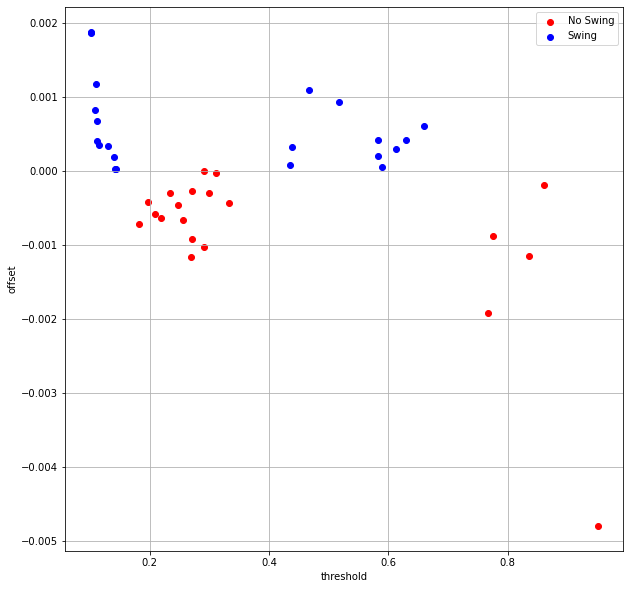

In [246]:
# dfc.loc[(dfc["threshold"] > 0.95), "threshold"] = 0.95
# dfc['polythreshold'] = polycoefs[0] + polycoefs[1]*dfc["threshold"] + polycoefs[2]*dfc["threshold"]**2
# df_balls['polythreshold'] = polycoefs[0] + polycoefs[1]*df_balls["threshold"] + polycoefs[2]*df_balls["threshold"]**2
# (0.05 + 0.7*x + 0.4*x**2)
# dfc['polythreshold'] = 0.05 + 0.7*dfc["threshold"] + 0.4*dfc["threshold"]**2
# df_balls['polythreshold'] = 0.05 + 0.7*df_balls["threshold"] + 0.4*df_balls["threshold"]**2
# df_balls.loc[(df_balls["polythreshold"] > 0.95), "polythreshold"] = 0.95
# df_balls.loc[(df_balls["polythreshold"] < 0.10), "polythreshold"] = 0.10

dfc["offset"] = dfc["roll"] - dfc["threshold"]
df_balls["offset"] = df_balls["roll"] - df_balls["threshold"]
# dfc["offset"] = dfc["roll"] - dfc["polythreshold"]
# df_balls["offset"] = df_balls["roll"] - df_balls["polythreshold"]


# outliers = df_balls.copy()[
#     (df_balls["passed"] & (df_balls["offset"] > 0)) | (~df_balls["passed"] & (df_balls["offset"] < 0))
# ]
outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
outliers = outliers[outliers["threshold"] > 0.1]
print(len(outliers))

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Swing",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Swing",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.grid()
ax.legend()
# ax.set_xlim(0.52, 0.54)
# ax.set_xlim(0, 1.0)
# ax.set_ylim(-0.01, 0.01)
fig.savefig("../figures/swing_fit_outliers.png", facecolor="white")

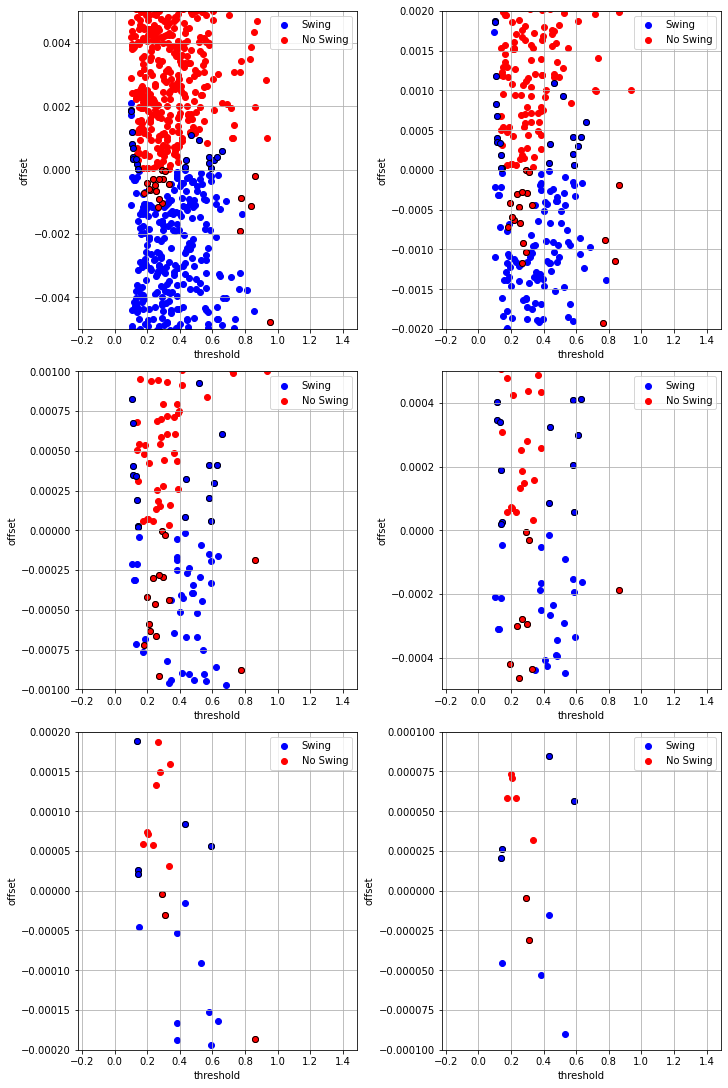

In [250]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15), layout="constrained")
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Swing",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Swing",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    # ax.set_yscale("log")
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/swing_ball_fit_offsets.png", facecolor="white")

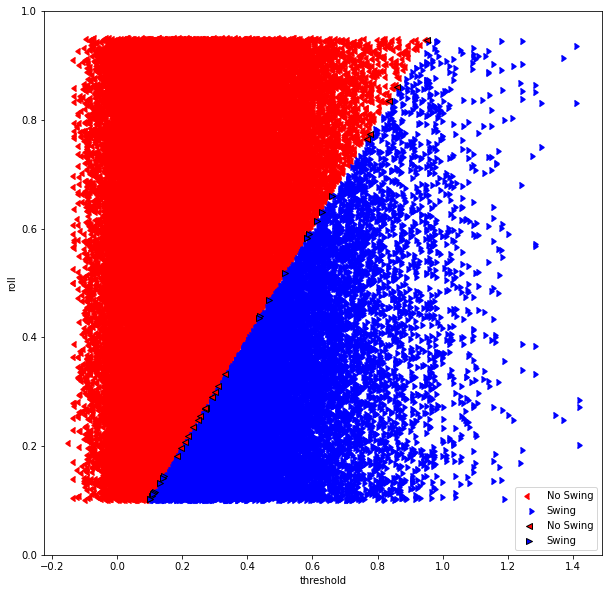

In [248]:
# x_val = "ruth_vibes"
x_val = "threshold"

# y_val = df_balls
y_val = dfc

# polycoefs = (series_s.convert().coef + series_l.convert().coef) / 2
# print(polycoefs)
linex = np.linspace(0, 1, 100)
fig, axN = plt.subplots(1, figsize=(10, 10))
# for axN in ax:
#     if axN == ax[0]:
axN.scatter(
    y_val[~y_val["passed"]][x_val],
    y_val[~y_val["passed"]]["roll"],
    color="red",
    label="No Swing",
    marker=CARETLEFTBASE,
)
axN.scatter(
    y_val[y_val["passed"]][x_val],
    y_val[y_val["passed"]]["roll"],
    color="blue",
    label="Swing",
    marker=CARETRIGHTBASE,
)
axN.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["roll"],
    color="red",
    marker="<",
    label="No Swing",
    edgecolor="k",
)
axN.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["roll"],
    color="blue",
    marker=">",
    label="Swing",
    edgecolor="k",
)
#     else:
#         axN.scatter(y_val[y_val['passed']][x_val], y_val[y_val['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
#         axN.scatter(y_val[~y_val['passed']][x_val], y_val[~y_val['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)
#         axN.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"], color="red", marker = '<', label="No Swing", edgecolor='k')
#         axN.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"], color="blue", marker = '>', label="Swing", edgecolor='k')

#         axN.scatter(y_val[x_val], y_val["roll"], c=y_val['passed'], label="No Swing", marker='.')
#     axN.plot(linex, polycoefs[0] + polycoefs[1]*linex + polycoefs[2]*linex**2, 'k')
# ax.plot(np.linspace(0,1,100), series_s(np.linspace(0,1,100)), 'k')
# xline = np.array(ax.get_xlim())
# yline = -intercept_scaled + xline
# # yline = -0.2 + xline
# ax.plot(xline, yline, 'k')

axN.set_xlabel(x_val)
axN.set_ylabel("roll")
axN.set_ylim(0, 1)
# axN.set_xlim(-0.1, 0.1)
# axN.set_ylim(0, 0.2)
# ax.set_yscale('log')
# ax.set_xlim(0.484, 0.499)

axN.legend(loc="lower right")

# fig.savefig("../figures/"+ x_val + ".png", facecolor="white")

In [249]:
pd.set_option("display.max_columns", None)

col_list = [
    "event_type",
    "roll",
    "threshold",
    "offset",
    "mox_vibes",
    "invpath_scaled",
    "ruth_vibes",
    "batter_vibes",
    "pitcher_vibes",
    "batter_mul",
    "pitcher_mul",
    "ballpark_viscosity",
    "batter_name",
    "pitcher_name",
    "game_id",
    "play_count",
    "batter_mods",
    "pitcher_mods",
    "batting_team_mods",
    "pitching_team_mods",
    "season",
    "day",
    "game_id",
    "play_count",
]
# outliers[(outliers['threshold'] > 0.1) &
#          (outliers["batter_mods"].astype(str).str.contains("ON_FIRE"))].sort_values('offset', ascending=True).loc[:, col_list][0:10]
outliers[(outliers["threshold"] > 0.1)].sort_values("offset", ascending=False).loc[:, col_list]

# 3805, 50620, 38777

,event_type,roll,threshold,offset,mox_vibes,invpath_scaled,ruth_vibes,batter_vibes,pitcher_vibes,batter_mul,pitcher_mul,ballpark_viscosity,batter_name,pitcher_name,game_id,play_count,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count
72410,Foul,0.103295,0.101421,0.001874,0.280631,0.999000,0.317502,-0.396893,-0.348135,1.0,1.0,0.500000,Son Scotch,Nandy Slumps,5be88f2a-26c8-4fc2-8993-a444094d7099,212,NaN,NaN,NaN,NaN,12,14,5be88f2a-26c8-4fc2-8993-a444094d7099,212
246188,StrikeSwinging,0.103497,0.101634,0.001863,0.546675,0.726231,0.315737,0.087454,0.222129,1.0,1.0,0.500000,Hendricks Richardson,Jordan Hildebert,ad7b64e9-06a1-4464-a57c-0ed53db6e992,127,NaN,FRIEND_OF_CROWS;SIPHON,BASE_INSTINCTS,NaN,12,34,ad7b64e9-06a1-4464-a57c-0ed53db6e992,127
261977,Foul,0.110952,0.109774,0.001177,0.403540,0.999000,0.386998,0.233212,0.274044,1.0,1.0,0.500000,Tamara Crankit,Flattery McKinley,fe8cae32-068f-4b77-a100-ed86a6f06d1d,94,NaN,NaN,EXTRA_STRIKE,UNDERSEA,12,48,fe8cae32-068f-4b77-a100-ed86a6f06d1d,94
95760,Foul,0.468446,0.467358,0.001088,0.382971,0.112529,0.603849,-0.774578,-0.176558,1.0,1.0,0.575186,Bevan Wise,Tot Clark,bf92598c-1ea6-46de-89d5-e3665a9a1d40,31,NaN,TRIPLE_THREAT,O_NO,PARTY_TIME,12,92,bf92598c-1ea6-46de-89d5-e3665a9a1d40,31
137142,Out,0.517530,0.516603,0.000927,0.467153,0.256128,0.792677,0.691067,-0.104593,1.0,1.0,0.500000,Fran Beans,Yummy Elliott,f025ce23-a552-4bfb-9aa4-bf9d2eb60327,97,SWIM_BLADDER,NaN,NaN,NaN,12,57,f025ce23-a552-4bfb-9aa4-bf9d2eb60327,97
124310,Foul,0.109000,0.108175,0.000824,1.016986,0.999000,0.639407,0.838043,-0.630692,1.0,1.0,0.500000,Fish Summer,Finn James,9555df5d-635a-4497-bc0c-919a4305af0b,275,FIRE_EATER,WILD,EARLBIRDS,CARCINIZATION;EXTRA_STRIKE,12,71,9555df5d-635a-4497-bc0c-919a4305af0b,275
136196,Foul,0.112867,0.112191,0.000676,1.335922,0.770591,0.686001,0.570963,-0.936469,1.0,1.0,0.500000,Aldon Cashmoney,Sexton Wheerer,7e257c48-8b5f-466b-ba50-b0d6ec138e9f,138,SPICY,ALTERNATE;SUPERALLERGIC;FRIEND_OF_CROWS,BASE_INSTINCTS,NaN,12,56,7e257c48-8b5f-466b-ba50-b0d6ec138e9f,138
100476,Foul,0.659899,0.659296,0.000603,0.627410,0.726231,1.229465,0.838787,0.598485,1.0,1.0,0.544272,Hendricks Richardson,Conrad Vaughan,c4f1914e-2b98-4b8e-b3d0-89af4dda93bc,144,NaN,NaN,BASE_INSTINCTS;PARTY_TIME,EXTRA_STRIKE;PARTY_TIME,12,96,c4f1914e-2b98-4b8e-b3d0-89af4dda93bc,144
88849,StrikeSwinging,0.629743,0.629332,0.000411,0.424509,0.406228,0.988037,-0.477608,-0.499512,1.0,1.0,0.500000,Hahn Fox,Qais Dogwalker,63fbb905-bba5-482c-9b4c-9efbc1ec3e02,225,NaN,FRIEND_OF_CROWS,BASE_INSTINCTS,LIFE_OF_PARTY;ELECTRIC,12,26,63fbb905-bba5-482c-9b4c-9efbc1ec3e02,225
78692,StrikeSwinging,0.582857,0.582447,0.000410,0.309070,0.951589,1.105103,-0.235851,0.028045,1.0,1.0,0.500000,Silvaire Roadhouse,Uncle Plasma,236eab5f-dc24-4914-aa8c-4859bac4a6ab,187,FLINCH,HARD_BOILED,CARCINIZATION;EXTRA_STRIKE,BIRD_SEED,12,20,236eab5f-dc24-4914-aa8c-4859bac4a6ab,187


In [104]:
# out1 = outliers.loc[24214,col_list]
# out1 = outliers.loc[26207,col_list]
out1 = outliers.loc[64778, col_list]
out1

KeyError: 64778

In [ ]:
# was this a strike?
# constant = 0.2 if not self.is_flinching() else 0.4
# threshold = constant + 0.3 * (ruth * (1 + 0.2 * vibes)) + 0.2 * fwd + 0.1 * musc
# threshold = min(threshold, 0.85)
# strike: 0.0.7059653767216438
# 0.2 + 0.3*out1['ruth_vibes'] + 0.2*out1['ballpark_forwardness'] + 0.1*out1['batter_musclitude']
# out1['threshold']

In [ ]:
out1.roll

In [ ]:
-1 * (
    1.0 * coef_list[2] * out1["mox_vibes"]
    + 1.0 * coef_list[3] * out1["invpath_scaled"]
    + 1.0 * coef_list[1] * out1["ruth_vibes"]
    + 1.0 * coef_list[4] * out1["ballpark_viscosity"]
    + intercept_scaled[0]
)

In [ ]:
# print(out1['batter_moxie'] * (1 + 0.2*out1['batter_vibes'])*2.1)
print(out1["mox_vibes"], out1["mox_vibes"] / out1["batter_mul"])
# print(1*(1 - out1['batter_patheticism']))
print(out1["invpath_scaled"])

In [ ]:
# newpath = (1 - out1['batter_patheticism']/2.25)
# newpath

In [ ]:
# newmox = out1['batter_moxie'] * (1 + 0.2*out1['batter_vibes'])*2.25
# newmox

In [ ]:
# -1*(1.0 * newmox*0.26680261578837383 + \
#     1.0 * 0.27074297728503854*newpath + \
#     1.0 * -0.6493800663604212*out1['ruth_vibes'] + \
#     1.0 * -0.2178580998442087*out1['ballpark_viscosity'] + \
#     intercept_scaled[0])

In [ ]:
coef_list

In [ ]:
X.columns

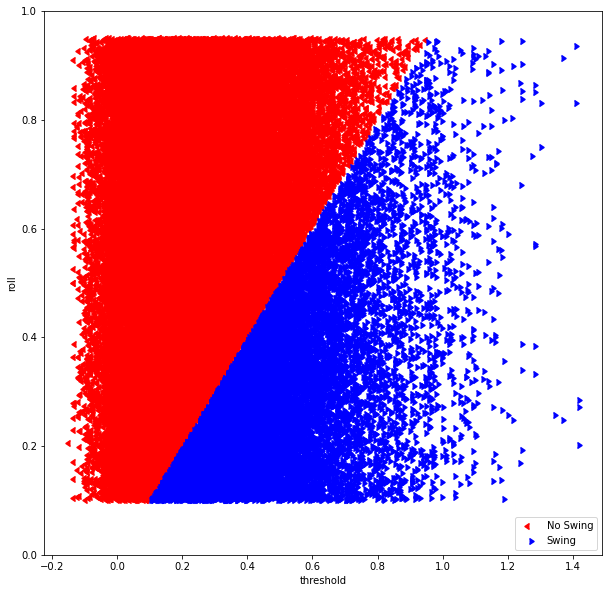

In [241]:
# x_val = "ruth_vibes"
x_val = "threshold"

# y_val = df_balls[df_balls["batter_eye"] > 0].copy()
y_val = dfc

# polycoefs = (series_s.convert().coef + series_l.convert().coef) / 2
# print(polycoefs)
# linex = np.linspace(0, 1, 100)
fig, axN = plt.subplots(1, figsize=(10, 10))
# for axN in ax:
#     if axN == ax[0]:
axN.scatter(
    y_val[~y_val["passed"]][x_val],
    y_val[~y_val["passed"]]["roll"],
    color="red",
    label="No Swing",
    marker=CARETLEFTBASE,
)
axN.scatter(
    y_val[y_val["passed"]][x_val],
    y_val[y_val["passed"]]["roll"],
    color="blue",
    label="Swing",
    marker=CARETRIGHTBASE,
)
# axN.scatter(
#     outliers[~outliers["passed"]][x_val],
#     outliers[~outliers["passed"]]["roll"],
#     color="red",
#     marker="<",
#     label="No Swing",
#     edgecolor="k",
# )
# axN.scatter(
#     outliers[outliers["passed"]][x_val],
#     outliers[outliers["passed"]]["roll"],
#     color="blue",
#     marker=">",
#     label="Swing",
#     edgecolor="k",
# )
#     else:
#         axN.scatter(y_val[y_val['passed']][x_val], y_val[y_val['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
#         axN.scatter(y_val[~y_val['passed']][x_val], y_val[~y_val['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)
#         axN.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"], color="red", marker = '<', label="No Swing", edgecolor='k')
#         axN.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"], color="blue", marker = '>', label="Swing", edgecolor='k')

#         axN.scatter(y_val[x_val], y_val["roll"], c=y_val['passed'], label="No Swing", marker='.')
#     axN.plot(linex, polycoefs[0] + polycoefs[1]*linex + polycoefs[2]*linex**2, 'k')
# ax.plot(np.linspace(0,1,100), series_s(np.linspace(0,1,100)), 'k')
# xline = np.array(ax.get_xlim())
# yline = -intercept_scaled + xline
# # yline = -0.2 + xline
# ax.plot(xline, yline, 'k')

axN.set_xlabel(x_val)
axN.set_ylabel("roll")
axN.set_ylim(0, 1)
# axN.set_xlim(-0.1, 0.1)
# axN.set_ylim(0, 0.2)
# ax.set_yscale('log')
# ax.set_xlim(0.484, 0.499)

axN.legend(loc="lower right")

# fig.savefig("../figures/"+ x_val + ".png", facecolor="white")

In [242]:
y_val

,event_type,roll,passed,batter_buoyancy,batter_divinity,batter_martyrdom,batter_moxie,batter_musclitude,batter_patheticism,batter_thwackability,batter_tragicness,batter_coldness,batter_overpowerment,batter_ruthlessness,batter_shakespearianism,batter_suppression,batter_unthwackability,batter_base_thirst,batter_continuation,batter_ground_friction,batter_indulgence,batter_laserlikeness,batter_anticapitalism,batter_chasiness,batter_omniscience,batter_tenaciousness,batter_watchfulness,batter_pressurization,batter_cinnamon,batter_multiplier,runner_on_first_base_thirst,runner_on_first_continuation,runner_on_first_ground_friction,runner_on_first_indulgence,runner_on_first_laserlikeness,runner_on_first_multiplier,runner_on_second_base_thirst,runner_on_second_continuation,runner_on_second_ground_friction,runner_on_second_indulgence,runner_on_second_laserlikeness,runner_on_second_multiplier,runner_on_third_base_thirst,runner_on_third_continuation,runner_on_third_ground_friction,runner_on_third_indulgence,runner_on_third_laserlikeness,runner_on_third_multiplier,pitcher_buoyancy,pitcher_divinity,pitcher_martyrdom,pitcher_moxie,pitcher_musclitude,pitcher_patheticism,pitcher_thwackability,pitcher_tragicness,pitcher_ruthlessness,pitcher_overpowerment,pitcher_unthwackability,pitcher_shakespearianism,pitcher_suppression,pitcher_coldness,pitcher_base_thirst,pitcher_continuation,pitcher_ground_friction,pitcher_indulgence,pitcher_laserlikeness,pitcher_anticapitalism,pitcher_chasiness,pitcher_omniscience,pitcher_tenaciousness,pitcher_watchfulness,pitcher_pressurization,pitcher_cinnamon,pitcher_multiplier,fielder_anticapitalism,fielder_chasiness,fielder_omniscience,fielder_tenaciousness,fielder_watchfulness,fielder_multiplier,ballpark_grandiosity,ballpark_fortification,ballpark_obtuseness,ballpark_ominousness,ballpark_inconvenience,ballpark_viscosity,ballpark_forwardness,ballpark_mysticism,ballpark_elongation,ballpark_filthiness,what1,what2,batting_team_hype,pitching_team_hype,batter_name,pitcher_name,fielder_name,runner_on_first_name,runner_on_second_name,runner_on_third_name,batter_vibes,pitcher_vibes,fielder_vibes,runner_on_first_vibes,runner_on_second_vibes,runner_on_third_vibes,batter_mods,batting_team_mods,pitcher_mods,pitching_team_mods,fielder_mods,runner_on_first_mods,runner_on_second_mods,runner_on_third_mods,game_id,stadium_id,play_count,weather,ball_count,strike_count,out_count,season,day,top_of_inning,home_score,away_score,inning,batting_team_roster_size,pitching_team_roster_size,baserunner_count,is_strike,strike_roll,strike_threshold,fielder_roll,batter_consecutive_hits,batter_mul,pitcher_mul,ruth_scaled,mox_scaled,path_scaled,batter_eye,invpath,invpath_scaled,ruth_vibes,mox_vibes,invpath_vibes,visc_filth,ruth_times_vibes,mox_times_vibes,path_times_vibes,ruth_sq,mox_sq,visc_sq,ruthsq,pathsq,moxsq,viscsq,ruthmox,ruthpath,ruthvisc,moxpath,moxvisc,pathvisc,moxpluspath,mpsq,ruthmp,viscmp,ruthpluseye,rutheyesq,viscrutheye,threshold,offset
0,StrikeSwinging,0.206466,True,0.674819,0.859965,0.662517,0.376634,0.972323,0.798646,0.813707,0.100000,0.485380,0.939029,0.758789,0.657075,0.721019,0.180179,0.659993,0.668103,0.224341,0.848480,0.604986,0.010000,0.656664,0.642409,0.461485,0.010000,0.615293,0.595586,1.0,0.000000,0.000000,0.00000,0.00000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00,0.000000,0.000000,0.00000,1.0,0.248164,0.261652,0.757479,0.812513,0.471119,0.631332,0.825164,0.732811,0.989156,0.741194,0.853830,0.975299,0.505620,0.899684,0.661875,0.004413,0.616237,0.872523,0.898158,0.876634,0.624356,0.067703,0.256976,0.312692,0.949973,0.951445,1.0,0,0,0,0,0,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.0,0.102390,0,0,Bates Bentley,Zoey Kirchner,NaN,NaN,NaN,NaN,0.595586,0.951445,0,0.00000,0.0,0.000000,NaN,NaN,NaN,MAINTENANCE_MODE,NaN,NaN,NaN,NaN,4ce29cb6-6ae4-45f6-99df-2be2e71ad824,NaN,4,Weather.SUN_2,0,0,0,12,0,True,0.0,0.0,0,13,14,0,False,0.867910,0.750447,NaN,0,1.0,1.0,0.989156,0.376634,0